# 📅 Google Calendar Export Explorer

This notebook helps you explore and analyze your exported Google Calendar data.

## Features:
- 📊 Load and explore calendar JSON exports
- 🔍 Search and filter events
- 📈 Visualize calendar patterns
- 📋 Generate insights and statistics
- 🗓️ Analyze event types and trends

## Getting Started:
1. Export your calendar data using: `uv run python main.py`
2. Update the filename in the cell below
3. Run all cells to explore your data!


In [85]:
# Import necessary libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Any
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("📚 Libraries imported successfully!")
print("🎨 Plotting style configured!")
print("\n📁 Make sure you have a calendar export JSON file ready.")


📚 Libraries imported successfully!
🎨 Plotting style configured!

📁 Make sure you have a calendar export JSON file ready.


In [86]:
# Load calendar export data
# 🔧 Update this filename to match your export file
EXPORT_FILE = "calendar_export.json"  # Change this to your actual filename

def load_calendar_data(filename: str) -> Dict[str, Any]:
    """Load calendar export JSON data."""
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✅ Successfully loaded calendar data from {filename}")
        return data
    except FileNotFoundError:
        print(f"❌ File {filename} not found!")
        print("💡 Make sure to export your calendar first:")
        print("   uv run python main.py")
        return {}
    except json.JSONDecodeError as e:
        print(f"❌ Error parsing JSON: {e}")
        return {}

# Load the data
calendar_data = load_calendar_data(EXPORT_FILE)

if calendar_data:
    print("\n📊 Calendar Export Summary:")
    print(f"   Export timestamp: {calendar_data.get('export_timestamp', 'Unknown')}")
    print(f"   Total events: {calendar_data.get('total_events', 0)}")
    
    calendar_info = calendar_data.get('calendar_info', {})
    if calendar_info:
        print(f"   Calendar: {calendar_info.get('summary', 'Unknown')}")
        print(f"   Calendar ID: {calendar_info.get('id', 'Unknown')}")
        print(f"   Access role: {calendar_info.get('access_role', 'Unknown')}")
    
    events = calendar_data.get('events', [])
    print(f"\n🎯 Ready to analyze {len(events)} events!")
    

✅ Successfully loaded calendar data from calendar_export.json

📊 Calendar Export Summary:
   Export timestamp: 2025-06-11T10:50:00.218362Z
   Total events: 190

🎯 Ready to analyze 190 events!


In [91]:
# Convert to pandas DataFrame for easier analysis
def create_events_dataframe(events: List[Dict[str, Any]]) -> pd.DataFrame:
    """Convert events to a pandas DataFrame."""
    if not events:
        return pd.DataFrame()
    
    # Extract key fields from events
    df_data = []
    for event in events:
        row = {
            'summary': event.get('summary', 'No Title'),
            'start_time': event.get('start_time', ''),
            'end_time': event.get('end_time', ''),
            'all_day': event.get('all_day', False),
            'timezone': event.get('timezone', ''),
            'attendees_count': event.get('attendees_count', 0),
            'organizer_email': event.get('organizer', {}).get('email', ''),
            #'has_attendees': event.get('attendees_count', 0) > 0,
            'event_type': event.get('event_type', 'default'),
            'has_recurrence': bool(event.get('recurring_event_id', '')),
            'color_id': event.get('color_id', ''),
        }
        df_data.append(row)
    
    df = pd.DataFrame(df_data)
    
    # Parse datetime columns
    def parse_datetime(dt_str):
        if not dt_str:
            return None
        try:
            # Try parsing with timezone
            if '+' in dt_str or dt_str.endswith('Z'):
                return pd.to_datetime(dt_str)
            # Try parsing date-only
            else:
                return pd.to_datetime(dt_str)
        except Exception as e:
            print(f"An error occurred: {e}")
            return None
    
    df['start_datetime'] = df['start_time'].apply(parse_datetime)
    df['end_datetime'] = df['end_time'].apply(parse_datetime)
    
    # Calculate duration for timed events
    mask = df['start_datetime'].notna() & df['end_datetime'].notna() & ~df['all_day']
    duration_timedelta = df.loc[mask, 'end_datetime'] - df.loc[mask, 'start_datetime']
    df.loc[mask, 'duration_hours'] = pd.to_timedelta(duration_timedelta).dt.total_seconds() / 3600
    
    #Extract date components (handle None values properly)
    df['date'] = df['start_datetime'].apply(lambda x: x.date() if pd.notnull(x) else None)
    df['hour'] = df['start_datetime'].apply(lambda x: x.hour if pd.notnull(x) else None)
    df['weekday'] = df['start_datetime'].apply(lambda x: x.day_name() if pd.notnull(x) else None)
    df['month'] = df['start_datetime'].apply(lambda x: x.month_name() if pd.notnull(x) else None)
    
    # filter events to only return default
    default_events_df = df[df['event_type'] == 'default']
    
    return default_events_df

# Create DataFrame if we have events
if calendar_data and 'events' in calendar_data:
    events_df = create_events_dataframe(calendar_data['events'])
    
    if not events_df.empty:
        print(f"📋 Created DataFrame with {len(events_df)} events")
        #print(f"📅 Date range: {events_df['date'].min()} to {events_df['date'].max()}")
        print("\n🔍 DataFrame columns:")
        for col in events_df.columns:
            print(f"   • {col}")
    else:
        print("❌ No events to analyze")
        events_df = pd.DataFrame()
else:
    print("❌ No calendar data loaded")
    events_df = pd.DataFrame()


📋 Created DataFrame with 50 events

🔍 DataFrame columns:
   • summary
   • start_time
   • end_time
   • all_day
   • timezone
   • attendees_count
   • organizer_email
   • event_type
   • has_recurrence
   • color_id
   • start_datetime
   • end_datetime
   • duration_hours
   • date
   • hour
   • weekday
   • month


In [92]:
events_df

,summary,start_time,end_time,all_day,timezone,attendees_count,organizer_email,event_type,has_recurrence,color_id,start_datetime,end_datetime,duration_hours,date,hour,weekday,month
3,busy,2025-04-14T13:00:00-03:00,2025-04-14T13:50:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,True,5,2025-04-14 13:00:00-03:00,2025-04-14 13:50:00-03:00,0.833333,2025-04-14,13,Monday,April
7,busy,2025-04-15T13:00:00-03:00,2025-04-15T13:50:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,False,5,2025-04-15 13:00:00-03:00,2025-04-15 13:50:00-03:00,0.833333,2025-04-15,13,Tuesday,April
11,busy,2025-04-16T13:00:00-03:00,2025-04-16T13:50:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,True,5,2025-04-16 13:00:00-03:00,2025-04-16 13:50:00-03:00,0.833333,2025-04-16,13,Wednesday,April
20,ferias line,2025-04-22,2025-05-01,True,,0,andre.costa@nubank.com.br,default,False,,2025-04-22 00:00:00,2025-05-01 00:00:00,NaN,2025-04-22,0,Tuesday,April
27,Training,2025-04-23T16:00:00-03:00,2025-04-23T16:50:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,False,1,2025-04-23 16:00:00-03:00,2025-04-23 16:50:00-03:00,0.833333,2025-04-23,16,Wednesday,April
34,No Title,2025-04-25T16:30:00-03:00,2025-04-25T16:55:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,False,5,2025-04-25 16:30:00-03:00,2025-04-25 16:55:00-03:00,0.416667,2025-04-25,16,Friday,April
35,tennis,2025-04-25T17:00:00-03:00,2025-04-25T17:50:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,True,5,2025-04-25 17:00:00-03:00,2025-04-25 17:50:00-03:00,0.833333,2025-04-25,17,Friday,April
43,No Title,2025-04-29T13:00:00-03:00,2025-04-29T13:50:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,False,5,2025-04-29 13:00:00-03:00,2025-04-29 13:50:00-03:00,0.833333,2025-04-29,13,Tuesday,April
47,busy,2025-04-30T13:00:00-03:00,2025-04-30T13:30:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,True,5,2025-04-30 13:00:00-03:00,2025-04-30 13:30:00-03:00,0.500000,2025-04-30,13,Wednesday,April
53,No Title,2025-05-02T13:00:00-03:00,2025-05-02T13:50:00-03:00,False,America/Sao_Paulo,0,andre.costa@nubank.com.br,default,False,5,2025-05-02 13:00:00-03:00,2025-05-02 13:50:00-03:00,0.833333,2025-05-02,13,Friday,May


In [93]:
events_df['event_type'].unique()

array(['default'], dtype=object)

In [78]:
# Add this as a new cell after your data loading

# Custom color mapping based on your calendar categories
COLOR_CATEGORY_MAP = {
    '11': 'Relationships',    # Tomato (red)
    '6': 'Mgm',              # Tangerine (orange) 
    '10': 'mgm up',          # Basil (green)
    '4': 'LPI',              # Flamingo (red-orange)
    '3': 'Citizenship',      # Grape (purple)
    '9': 'Arcadia',          # Blueberry (blue)
    '1': 'Maestro/multi-repo', # Lavender (light purple)
    '8': 'Focus',            # Graphite (gray)
    '5': 'Blocks',           # Banana (yellow)
    '2': 'Acquisition',      # Sage (light green)
    '': 'Default',           # No color assigned
    None: 'Default'          # Handle None values
}

# Google Calendar event color reference (from API)
GOOGLE_COLOR_NAMES = {
    '1': 'Lavender',   # #a4bdfc
    '2': 'Sage',       # #7ae7bf  
    '3': 'Grape',      # #dbadff
    '4': 'Flamingo',   # #ff887c
    '5': 'Banana',     # #fbd75b
    '6': 'Tangerine',  # #ffb878
    '7': 'Peacock',    # #46d6db
    '8': 'Graphite',   # #e1e1e1
    '9': 'Blueberry',  # #5484ed
    '10': 'Basil',     # #51b749
    '11': 'Tomato',    # #dc2127
}

def map_color_to_category(color_id):
    """Map color_id to your custom category names."""
    return COLOR_CATEGORY_MAP.get(str(color_id), 'Unknown')

def map_color_to_google_name(color_id):
    """Map color_id to Google's standard color names."""
    return GOOGLE_COLOR_NAMES.get(str(color_id), 'Default')

# Apply the mapping to your events DataFrame
if not events_df.empty and 'color_id' in events_df.columns:
    events_df['category'] = events_df['color_id'].apply(map_color_to_category)
    events_df['google_color_name'] = events_df['color_id'].apply(map_color_to_google_name)
    
    print("✅ Color mapping applied!")
    print("\n📊 Category breakdown:")
    category_summary = events_df.groupby('category').agg({
        'summary': 'count',
        'duration_hours': 'sum'
    }).rename(columns={'summary': 'event_count'})
    
    # Add percentage of total time
    total_hours = category_summary['duration_hours'].sum()
    category_summary['time_percentage'] = (category_summary['duration_hours'] / total_hours * 100).round(1)
    
    # Sort by total hours descending
    category_summary = category_summary.sort_values('duration_hours', ascending=False)
    
    print(category_summary)

✅ Color mapping applied!

📊 Category breakdown:
                    event_count  duration_hours  time_percentage
category                                                        
Default                     202      212.333333             49.9
Mgm                          80       50.000000             11.7
Blocks                       50       37.083333              8.7
mgm up                       54       33.000000              7.7
Acquisition                  37       31.083333              7.3
Relationships                31       19.500000              4.6
LPI                          33       17.583333              4.1
Unknown                      22       16.750000              3.9
Maestro/multi-repo            7        5.416667              1.3
Focus                         4        3.166667              0.7


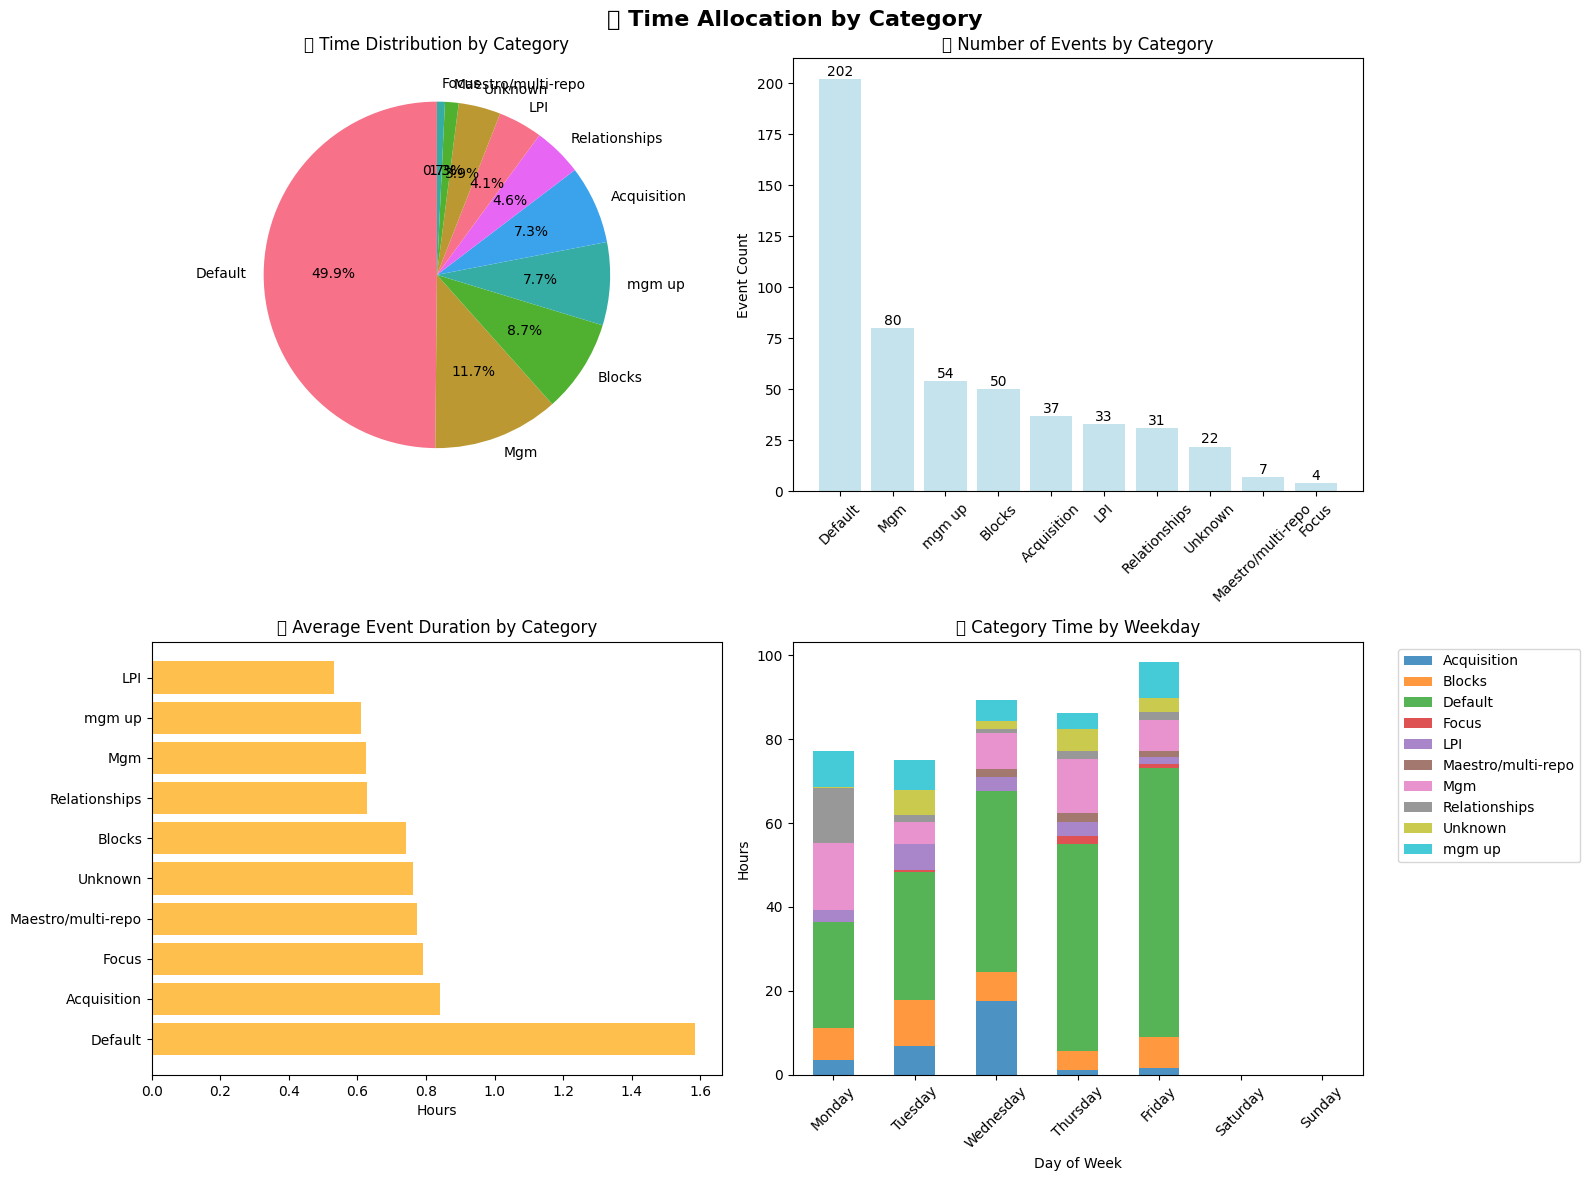


🔍 CATEGORY INSIGHTS

📋 Default:
   Total time: 212.3 hours (49.9%)
   Events: 202
   Avg duration: 1.6 hours
   Common times: 00:00, 12:00, 09:00

📋 Mgm:
   Total time: 50.0 hours (11.7%)
   Events: 80
   Avg duration: 0.6 hours
   Common times: 14:00, 16:00, 17:00

📋 Blocks:
   Total time: 37.1 hours (8.7%)
   Events: 50
   Avg duration: 0.7 hours
   Common times: 13:00, 09:00, 10:00

📋 mgm up:
   Total time: 33.0 hours (7.7%)
   Events: 54
   Avg duration: 0.6 hours
   Common times: 10:00, 15:00, 11:00

📋 Acquisition:
   Total time: 31.1 hours (7.3%)
   Events: 37
   Avg duration: 0.8 hours
   Common times: 10:00, 16:00, 17:00

📋 Relationships:
   Total time: 19.5 hours (4.6%)
   Events: 31
   Avg duration: 0.6 hours
   Common times: 10:00, 13:00, 16:00

📋 LPI:
   Total time: 17.6 hours (4.1%)
   Events: 33
   Avg duration: 0.5 hours
   Common times: 11:00, 14:00, 13:00

📋 Maestro/multi-repo:
   Total time: 5.4 hours (1.3%)
   Events: 7
   Avg duration: 0.8 hours
   Common times: 17

In [79]:
# Enhanced category-based analysis
if not events_df.empty and 'category' in events_df.columns:
    
    # Create a more meaningful visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📊 Time Allocation by Category', fontsize=16, fontweight='bold')
    
    # 1. Time spent by category (pie chart)
    category_hours = events_df.groupby('category')['duration_hours'].sum().sort_values(ascending=False)
    
    axes[0, 0].pie(category_hours.values, labels=category_hours.index, autopct='%1.1f%%', 
                   startangle=90)
    axes[0, 0].set_title('🥧 Time Distribution by Category')
    
    # 2. Event count by category (bar chart)
    category_counts = events_df['category'].value_counts()
    bars = axes[0, 1].bar(category_counts.index, category_counts.values, 
                         color='lightblue', alpha=0.7)
    axes[0, 1].set_title('📅 Number of Events by Category')
    axes[0, 1].set_ylabel('Event Count')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, category_counts.values):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       str(value), ha='center', va='bottom')
    
    # 3. Average event duration by category
    avg_duration = events_df.groupby('category')['duration_hours'].mean().sort_values(ascending=False)
    axes[1, 0].barh(avg_duration.index, avg_duration.values, color='orange', alpha=0.7)
    axes[1, 0].set_title('⏱️ Average Event Duration by Category')
    axes[1, 0].set_xlabel('Hours')
    
    # 4. Weekly pattern by category (if we have weekday data)
    if 'weekday' in events_df.columns:
        weekday_category = events_df.groupby(['weekday', 'category'])['duration_hours'].sum().unstack(fill_value=0)
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        weekday_category = weekday_category.reindex(weekday_order, fill_value=0)
        
        weekday_category.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                             colormap='tab10', alpha=0.8)
        axes[1, 1].set_title('📈 Category Time by Weekday')
        axes[1, 1].set_xlabel('Day of Week')
        axes[1, 1].set_ylabel('Hours')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed category insights
    print("\n🔍 CATEGORY INSIGHTS")
    print("=" * 50)
    
    for category in category_summary.index:
        if category != 'Unknown':
            cat_events = events_df[events_df['category'] == category]
            avg_duration = cat_events['duration_hours'].mean()
            total_hours = cat_events['duration_hours'].sum()
            event_count = len(cat_events)
            
            print(f"\n📋 {category}:")
            print(f"   Total time: {total_hours:.1f} hours ({category_summary.loc[category, 'time_percentage']:.1f}%)")
            print(f"   Events: {event_count}")
            print(f"   Avg duration: {avg_duration:.1f} hours")
            
            # Most common times for this category
            if 'hour' in cat_events.columns:
                common_hours = cat_events['hour'].value_counts().head(3)
                if not common_hours.empty:
                    print(f"   Common times: {', '.join([f'{int(h):02d}:00' for h in common_hours.index if pd.notna(h)])}")

In [76]:
events_df


,summary,start_time,end_time,all_day,timezone,status,visibility,attendees_count,creator_email,organizer_email,...,color_id,start_datetime,end_datetime,duration_hours,date,hour,weekday,month,category,google_color_name
0,Lucas' Vacation,2025-04-07,2025-04-17,True,,confirmed,default,4,,c_05316288925a48826543282c3646a0bc36a09316d9b9...,...,False,2025-04-07 00:00:00,2025-04-17 00:00:00,NaN,2025-04-07,0,Monday,April,Unknown,Default
1,Foundations - Bi-weekly Business Sprints,2025-04-14,2025-04-15,True,,confirmed,default,10,,jacqueline.asano@nubank.com.br,...,False,2025-04-14 00:00:00,2025-04-15 00:00:00,NaN,2025-04-14,0,Monday,April,Unknown,Default
2,Start Lucas M2,2025-04-14,2025-04-15,True,,confirmed,default,3,,andre.costa@nubank.com.br,...,False,2025-04-14 00:00:00,2025-04-15 00:00:00,NaN,2025-04-14,0,Monday,April,Unknown,Default
3,Home,2025-04-14,2025-04-15,True,,confirmed,default,0,,andre.costa@nubank.com.br,...,False,2025-04-14 00:00:00,2025-04-15 00:00:00,NaN,2025-04-14,0,Monday,April,Unknown,Default
4,Block,2025-04-14T09:00:00-03:00,2025-04-14T10:50:00-03:00,False,America/Sao_Paulo,confirmed,default,0,,andre.costa@nubank.com.br,...,False,2025-04-14 09:00:00-03:00,2025-04-14 10:50:00-03:00,1.833333,2025-04-14,9,Monday,April,Unknown,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,New Markets MR Next Steps,2025-06-10T15:30:00-03:00,2025-06-10T15:45:00-03:00,False,America/Sao_Paulo,confirmed,default,5,,andre.costa@nubank.com.br,...,True,2025-06-10 15:30:00-03:00,2025-06-10 15:45:00-03:00,0.250000,2025-06-10,15,Tuesday,June,Unknown,Default
516,Quick sync,2025-06-10T16:00:00-03:00,2025-06-10T16:15:00-03:00,False,America/Sao_Paulo,confirmed,default,3,,lucas.magalhaes@nubank.com.br,...,True,2025-06-10 16:00:00-03:00,2025-06-10 16:15:00-03:00,0.250000,2025-06-10,16,Tuesday,June,Unknown,Default
517,André / Bata,2025-06-10T16:30:00-03:00,2025-06-10T16:55:00-03:00,False,America/Sao_Paulo,confirmed,default,2,,lucas.batagliao@nubank.com.br,...,True,2025-06-10 16:30:00-03:00,2025-06-10 16:55:00-03:00,0.416667,2025-06-10,16,Tuesday,June,Unknown,Default
518,aniversário Renata,2025-06-11,2025-06-12,True,,confirmed,default,0,,andre.costa@nubank.com.br,...,False,2025-06-11 00:00:00,2025-06-12 00:00:00,NaN,2025-06-11,0,Wednesday,June,Unknown,Default


In [66]:
events_df[~events_df['has_recurrence']]

,summary,start_time,end_time,all_day,timezone,status,visibility,attendees_count,creator_email,organizer_email,event_type,has_recurrence,start_datetime,end_datetime,duration_hours,date,hour,weekday,month
6,Debriefing - Camila (*Software Engineer* (New) ),2025-05-12T11:30:00-03:00,2025-05-12T12:00:00-03:00,False,America/Sao_Paulo,confirmed,private,5,alice.lobos@nubank.com.br,nubank.com.br_5uqcl8kl6kdvrto2e71i6mc048@group...,default,False,2025-05-12 11:30:00-03:00,2025-05-12 12:00:00-03:00,0.500000,2025-05-12,11,Monday,May
12,Loan Acquisition Roles & Responsibilities,2025-05-12T14:30:00-03:00,2025-05-12T16:00:00-03:00,False,America/Sao_Paulo,confirmed,default,3,aline.moreira@nubank.com.br,aline.moreira@nubank.com.br,default,False,2025-05-12 14:30:00-03:00,2025-05-12 16:00:00-03:00,1.500000,2025-05-12,14,Monday,May
15,Arcadia <> PL,2025-05-12T17:30:00-03:00,2025-05-12T18:00:00-03:00,False,America/Sao_Paulo,confirmed,default,8,lucas.bussinati@nubank.com.br,lucas.bussinati@nubank.com.br,default,False,2025-05-12 17:30:00-03:00,2025-05-12 18:00:00-03:00,0.500000,2025-05-12,17,Monday,May
20,Policy Simulation Initiatives - Prioritization,2025-05-13T11:00:00-03:00,2025-05-13T12:00:00-03:00,False,America/Sao_Paulo,confirmed,default,7,tuanny.harumi@nubank.com.br,tuanny.harumi@nubank.com.br,default,False,2025-05-13 11:00:00-03:00,2025-05-13 12:00:00-03:00,1.000000,2025-05-13,11,Tuesday,May
22,No Title,2025-05-13T13:00:00-03:00,2025-05-13T13:50:00-03:00,False,America/Sao_Paulo,confirmed,private,0,andre.costa@nubank.com.br,andre.costa@nubank.com.br,default,False,2025-05-13 13:00:00-03:00,2025-05-13 13:50:00-03:00,0.833333,2025-05-13,13,Tuesday,May
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,Team Feedback - Paola,2025-06-23T15:30:00-03:00,2025-06-23T15:55:00-03:00,False,America/Sao_Paulo,confirmed,default,6,andre.costa@nubank.com.br,andre.costa@nubank.com.br,default,False,2025-06-23 15:30:00-03:00,2025-06-23 15:55:00-03:00,0.416667,2025-06-23,15,Monday,June
415,[Placeholder] Discussion: Leveraging Arcadia p...,2025-06-23T17:00:00-03:00,2025-06-23T17:50:00-03:00,False,America/Sao_Paulo,confirmed,default,3,andre.costa@nubank.com.br,andre.costa@nubank.com.br,default,False,2025-06-23 17:00:00-03:00,2025-06-23 17:50:00-03:00,0.833333,2025-06-23,17,Monday,June
440,Just do It Award,2025-06-25T15:00:00-03:00,2025-06-25T16:00:00-03:00,False,America/Sao_Paulo,confirmed,default,1,ive.andrade@nubank.com.br,nubank.com.br_stm1dmt2ock0439vdm44j3dfms@group...,default,False,2025-06-25 15:00:00-03:00,2025-06-25 16:00:00-03:00,1.000000,2025-06-25,15,Wednesday,June
442,Team Feedback - Tuanny,2025-06-25T16:30:00-03:00,2025-06-25T16:55:00-03:00,False,America/Sao_Paulo,confirmed,default,6,andre.costa@nubank.com.br,andre.costa@nubank.com.br,default,False,2025-06-25 16:30:00-03:00,2025-06-25 16:55:00-03:00,0.416667,2025-06-25,16,Wednesday,June


## 📊 Quick Data Overview


In [52]:
# Quick overview of the events data
if not events_df.empty:
    print("📈 EVENT STATISTICS")
    print("=" * 50)
    
    # Basic counts
    total_events = len(events_df)
    all_day_events = events_df['all_day'].sum()
    timed_events = total_events - all_day_events
    events_with_location = events_df['has_location'].sum()
    events_with_attendees = events_df['has_attendees'].sum()
    events_with_description = events_df['has_description'].sum()
    recurring_events = events_df['recurrence'].sum()
    
    print(f"📅 Total Events: {total_events}")
    print(f"⏰ Timed Events: {timed_events} ({timed_events/total_events*100:.1f}%)")
    print(f"📆 All-day Events: {all_day_events} ({all_day_events/total_events*100:.1f}%)")
    print(f"📍 Events with Location: {events_with_location} ({events_with_location/total_events*100:.1f}%)")
    print(f"👥 Events with Attendees: {events_with_attendees} ({events_with_attendees/total_events*100:.1f}%)")
    print(f"📝 Events with Description: {events_with_description} ({events_with_description/total_events*100:.1f}%)")
    print(f"🔄 Recurring Events: {recurring_events} ({recurring_events/total_events*100:.1f}%)")
    
    # Duration statistics
    timed_mask = events_df['duration_hours'].notna()
    if timed_mask.any():
        avg_duration = events_df.loc[timed_mask, 'duration_hours'].mean()
        median_duration = events_df.loc[timed_mask, 'duration_hours'].median()
        max_duration = events_df.loc[timed_mask, 'duration_hours'].max()
        
        print("\n⏱️ DURATION STATISTICS")
        print(f"   Average duration: {avg_duration:.1f} hours")
        print(f"   Median duration: {median_duration:.1f} hours")
        print(f"   Longest event: {max_duration:.1f} hours")
    
    # Display first few events
    print("\n📋 SAMPLE EVENTS (first 5)")
    print("-" * 50)
    display_cols = ['summary', 'start_time', 'all_day', 'attendees_count', 'has_location']
    print(events_df[display_cols].head())
    
else:
    print("❌ No events data to display")


📈 EVENT STATISTICS
📅 Total Events: 580
⏰ Timed Events: 513 (88.4%)
📆 All-day Events: 67 (11.6%)
📍 Events with Location: 44 (7.6%)
👥 Events with Attendees: 352 (60.7%)
📝 Events with Description: 179 (30.9%)
🔄 Recurring Events: 0 (0.0%)

⏱️ DURATION STATISTICS
   Average duration: 1.0 hours
   Median duration: 0.8 hours
   Longest event: 11.8 hours

📋 SAMPLE EVENTS (first 5)
--------------------------------------------------
                                    summary                 start_time  \
0  Foundations - Bi-weekly Business Sprints                 2025-05-12   
1                                      Home                 2025-05-12   
2                                     Block  2025-05-12T09:00:00-03:00   
3                Weekly Analytics Lead Sync  2025-05-12T10:00:00-03:00   
4               Planning | Loan Acquisition  2025-05-12T10:00:00-03:00   

   all_day  attendees_count  has_location  
0     True               10         False  
1     True                0         Fals

## 📈 Data Visualizations


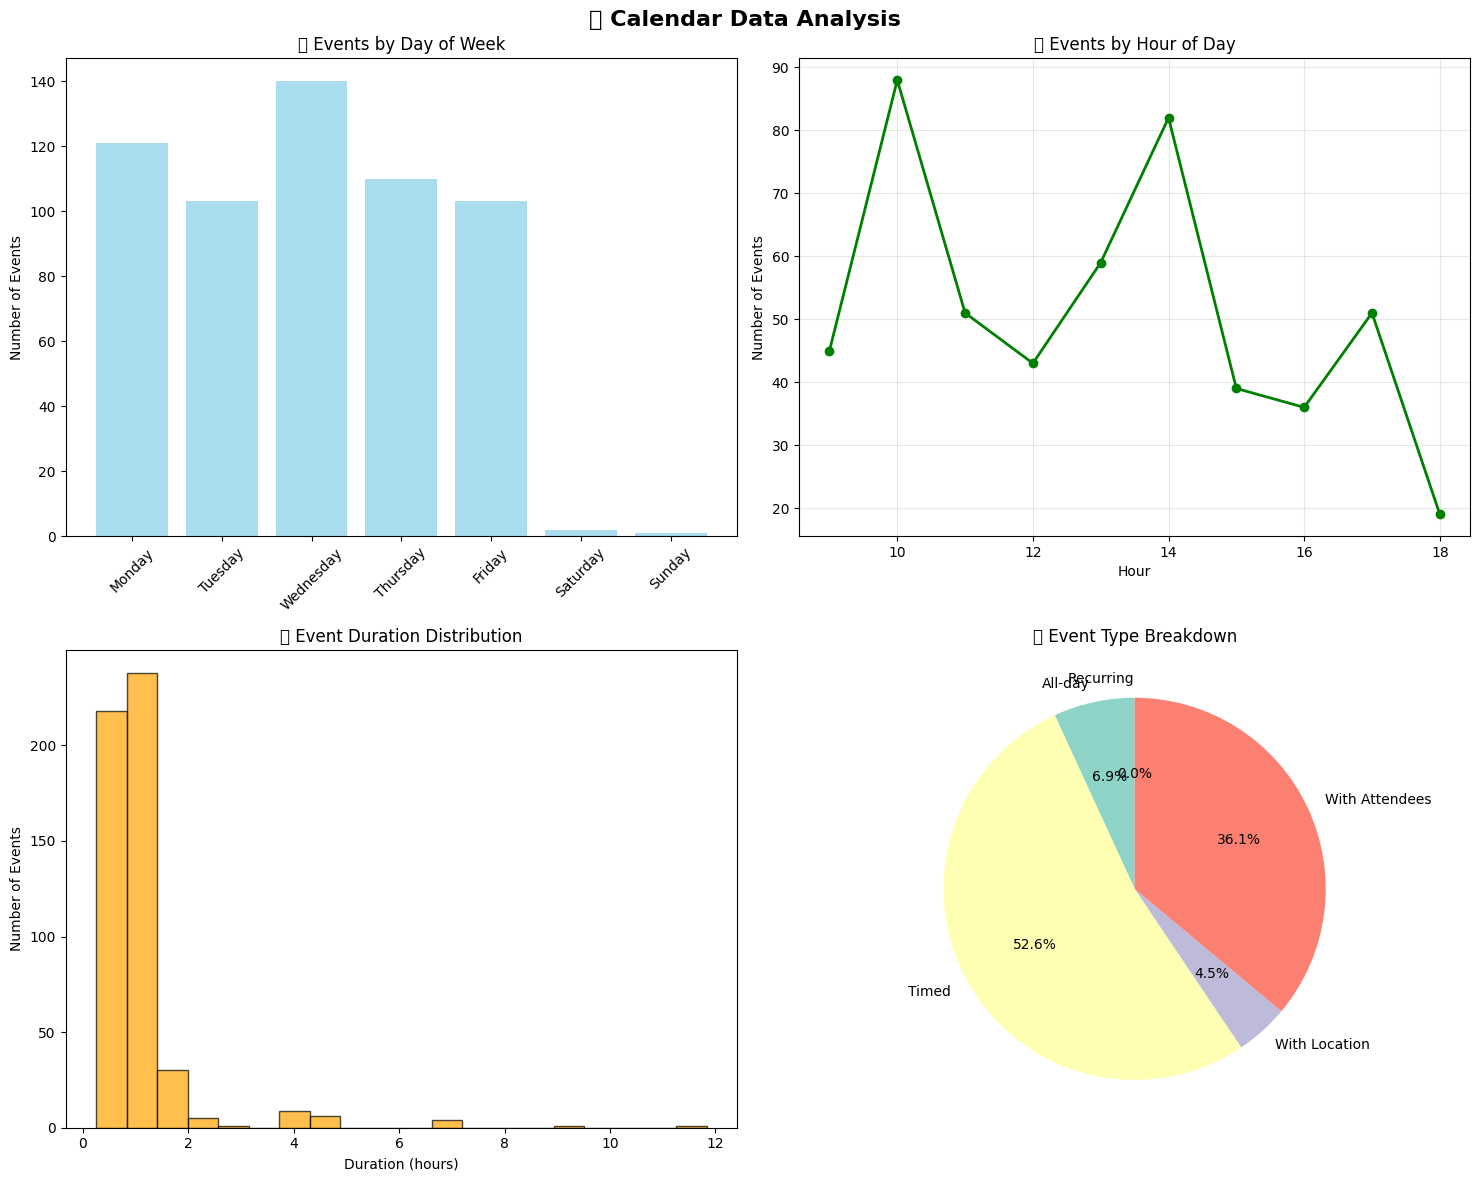

In [53]:
# Create visualizations
if not events_df.empty:
    # Set up the plot grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Calendar Data Analysis', fontsize=16, fontweight='bold')
    
    # 1. Events by weekday
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_counts = events_df['weekday'].value_counts().reindex(weekday_order, fill_value=0)
    
    axes[0, 0].bar(weekday_counts.index, weekday_counts.values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('📅 Events by Day of Week')
    axes[0, 0].set_ylabel('Number of Events')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Events by hour (for timed events only)
    timed_events = events_df[~events_df['all_day'] & events_df['hour'].notna()]
    if not timed_events.empty:
        hour_counts = timed_events['hour'].value_counts().sort_index()
        axes[0, 1].plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, color='green')
        axes[0, 1].set_title('⏰ Events by Hour of Day')
        axes[0, 1].set_xlabel('Hour')
        axes[0, 1].set_ylabel('Number of Events')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No timed events\nwith hour data', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('⏰ Events by Hour of Day')
    
    # 3. Event duration distribution
    duration_data = events_df['duration_hours'].dropna()
    if not duration_data.empty:
        axes[1, 0].hist(duration_data, bins=20, color='orange', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('⏱️ Event Duration Distribution')
        axes[1, 0].set_xlabel('Duration (hours)')
        axes[1, 0].set_ylabel('Number of Events')
    else:
        axes[1, 0].text(0.5, 0.5, 'No duration data\navailable', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('⏱️ Event Duration Distribution')
    
    # 4. Event type breakdown
    event_types = {
        'All-day': events_df['all_day'].sum(),
        'Timed': (~events_df['all_day']).sum(),
        'With Location': events_df['has_location'].sum(),
        'With Attendees': events_df['has_attendees'].sum(),
        'Recurring': events_df['recurrence'].sum()
    }
    
    axes[1, 1].pie(event_types.values(), labels=event_types.keys(), autopct='%1.1f%%', 
                   startangle=90, colors=sns.color_palette("Set3"))
    axes[1, 1].set_title('📊 Event Type Breakdown')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No data available for visualization")


## 🔍 Search and Filter Events


In [54]:
# Search and filter functions
def search_events(df, search_term, fields=['summary', 'description', 'location']):
    """Search for events containing a specific term."""
    if df.empty:
        return df
    
    mask = False
    for field in fields:
        if field in df.columns:
            mask |= df[field].str.contains(search_term, case=False, na=False)
    
    return df[mask]

def filter_events_by_date(df, start_date=None, end_date=None):
    """Filter events by date range."""
    if df.empty:
        return df
    
    mask = True
    if start_date:
        mask &= df['date'] >= pd.to_datetime(start_date).date()
    if end_date:
        mask &= df['date'] <= pd.to_datetime(end_date).date()
    
    return df[mask]

def filter_events_by_weekday(df, weekdays):
    """Filter events by specific weekdays."""
    if df.empty:
        return df
    
    if isinstance(weekdays, str):
        weekdays = [weekdays]
    
    return df[df['weekday'].isin(weekdays)]

# Example searches (modify these as needed)
if not events_df.empty:
    print("🔍 SEARCH EXAMPLES")
    print("=" * 50)
    
    # Search for meetings
    meeting_events = search_events(events_df, 'meeting')
    print(f"📅 Events containing 'meeting': {len(meeting_events)}")
    if not meeting_events.empty:
        print("Sample meeting events:")
        print(meeting_events[['summary', 'start_time', 'attendees_count']].head(3))
    
    print()
    
    # Find events with many attendees
    large_events = events_df[events_df['attendees_count'] >= 3]
    print(f"👥 Events with 3+ attendees: {len(large_events)}")
    if not large_events.empty:
        print("Large events:")
        print(large_events[['summary', 'attendees_count', 'start_time']].head(3))
    
    print()
    
    # Weekend events
    weekend_events = filter_events_by_weekday(events_df, ['Saturday', 'Sunday'])
    print(f"🎉 Weekend events: {len(weekend_events)}")
    
    print()
    
    # Long events (over 2 hours)
    long_events = events_df[events_df['duration_hours'] > 2]
    print(f"⏰ Events longer than 2 hours: {len(long_events)}")
    
else:
    print("❌ No events data for searching")


🔍 SEARCH EXAMPLES
📅 Events containing 'meeting': 50
Sample meeting events:
       summary                 start_time  attendees_count
23  LPI: Daily  2025-05-13T14:00:00-03:00                2
37  LPI: Daily  2025-05-14T14:00:00-03:00                2
52  LPI: Daily  2025-05-15T14:00:00-03:00                2

👥 Events with 3+ attendees: 143
Large events:
                                    summary  attendees_count  \
0  Foundations - Bi-weekly Business Sprints               10   
3                Weekly Analytics Lead Sync               36   
4               Planning | Loan Acquisition                3   

                  start_time  
0                 2025-05-12  
3  2025-05-12T10:00:00-03:00  
4  2025-05-12T10:00:00-03:00  

🎉 Weekend events: 3

⏰ Events longer than 2 hours: 22


## 📅 Calendar Pattern Analysis


In [55]:
# Calendar pattern analysis
if not events_df.empty:
    print("📊 CALENDAR PATTERNS")
    print("=" * 50)
    
    # Busiest days
    daily_counts = events_df['date'].value_counts().head(10)
    print("📆 Busiest Days:")
    for date, count in daily_counts.items():
        weekday = pd.to_datetime(date).day_name()
        print(f"   {date} ({weekday}): {count} events")
    
    print()
    
    # Most common event times
    if 'hour' in events_df.columns:
        common_hours = events_df['hour'].value_counts().head(5)
        print("⏰ Most Common Start Times:")
        for hour, count in common_hours.items():
            if pd.notna(hour):
                time_str = f"{int(hour):02d}:00"
                print(f"   {time_str}: {count} events")
    
    print()
    
    # Most frequent event titles (top 10)
    title_counts = events_df['summary'].value_counts().head(10)
    print("📋 Most Frequent Event Titles:")
    for title, count in title_counts.items():
        print(f"   {title}: {count} times")
    
    print()
    
    # Attendance patterns
    if events_df['attendees_count'].max() > 0:
        attendance_stats = events_df['attendees_count'].describe()
        print("👥 Attendance Patterns:")
        print(f"   Average attendees: {attendance_stats['mean']:.1f}")
        print(f"   Max attendees: {int(attendance_stats['max'])}")
        print(f"   Events with no attendees: {(events_df['attendees_count'] == 0).sum()}")
        
        # Attendance distribution
        attendance_counts = events_df['attendees_count'].value_counts().head(10)
        print("   Attendance distribution:")
        for attendees, count in attendance_counts.items():
            print(f"     {int(attendees)} attendees: {count} events")
    
    print()
    
    # Location analysis
    if events_df['has_location'].any():
        location_counts = events_df[events_df['has_location']]['location'].value_counts().head(10)
        print("📍 Most Common Locations:")
        for location, count in location_counts.items():
            if location.strip():  # Only show non-empty locations
                print(f"   {location}: {count} times")
    
else:
    print("❌ No events data for pattern analysis")


📊 CALENDAR PATTERNS
📆 Busiest Days:
   2025-06-11 (Wednesday): 19 events
   2025-06-25 (Wednesday): 19 events
   2025-07-02 (Wednesday): 17 events
   2025-05-12 (Monday): 17 events
   2025-05-15 (Thursday): 17 events
   2025-06-18 (Wednesday): 16 events
   2025-05-22 (Thursday): 16 events
   2025-07-09 (Wednesday): 15 events
   2025-06-09 (Monday): 15 events
   2025-06-05 (Thursday): 15 events

⏰ Most Common Start Times:
   10:00: 88 events
   14:00: 82 events
   00:00: 67 events
   13:00: 59 events
   11:00: 51 events

📋 Most Frequent Event Titles:
   Block: 73 times
   Home: 43 times
   Lunch: 43 times
   LPI: Daily: 32 times
   GT interview block: 31 times
   busy: 15 times
   Focus time: 11 times
   Lending DS Managers sync: 9 times
   Out of office: 9 times
   Andre / Tales: 9 times

👥 Attendance Patterns:
   Average attendees: 3.7
   Max attendees: 162
   Events with no attendees: 228
   Attendance distribution:
     0 attendees: 228 events
     2 attendees: 155 events
     1 att

## 🛠️ Custom Analysis Tools

Use the functions below to perform your own custom analysis:


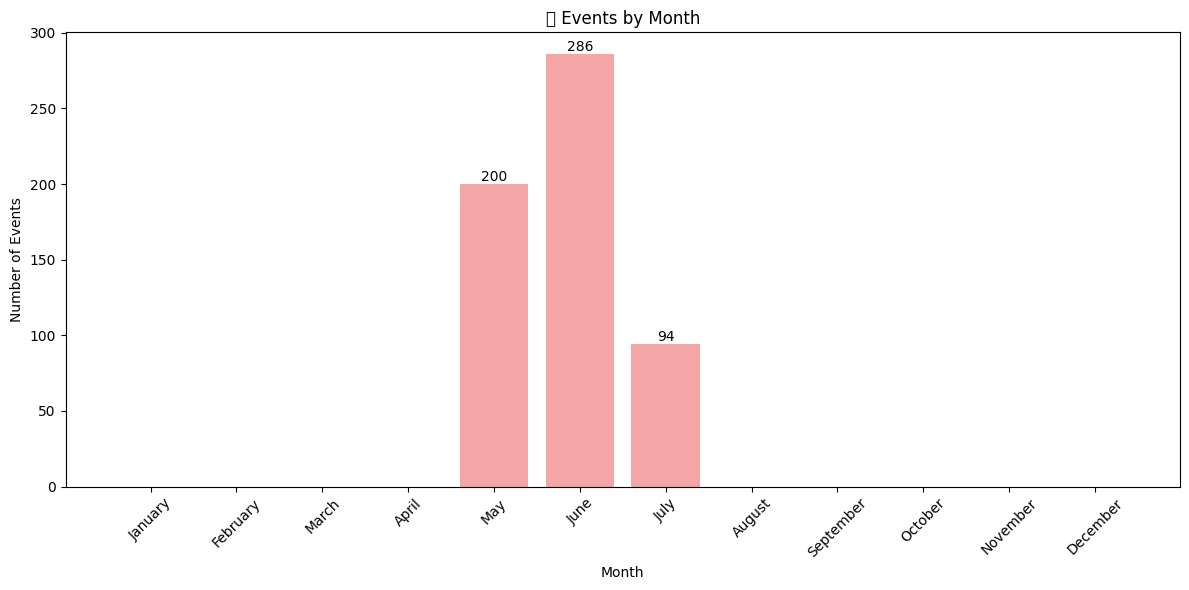

🛠️ Custom analysis tools loaded!
📝 Modify the commented examples above to run your own analysis.


In [56]:
# Custom analysis examples - modify these for your needs!

# Example 1: Search for specific terms
# search_term = "project"  # Change this to search for different terms
# results = search_events(events_df, search_term)
# print(f"Found {len(results)} events containing '{search_term}'")

# Example 2: Filter by date range
# start_date = "2024-01-01"  # Change these dates
# end_date = "2024-12-31"
# filtered_events = filter_events_by_date(events_df, start_date, end_date)
# print(f"Events between {start_date} and {end_date}: {len(filtered_events)}")

# Example 3: Analyze specific weekdays
# workdays = filter_events_by_weekday(events_df, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
# print(f"Workday events: {len(workdays)}")

# Example 4: Create a custom visualization
def create_monthly_timeline(df):
    """Create a timeline visualization by month."""
    if df.empty or 'month' not in df.columns:
        print("No data available for monthly timeline")
        return
    
    monthly_counts = df['month'].value_counts()
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    monthly_counts = monthly_counts.reindex(month_order, fill_value=0)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(monthly_counts.index, monthly_counts.values, color='lightcoral', alpha=0.7)
    plt.title('📅 Events by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Events')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, monthly_counts.values):
        if value > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    str(value), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Run the monthly timeline
if not events_df.empty:
    create_monthly_timeline(events_df)

# Example 5: Export filtered data
def export_filtered_events(df, filename="filtered_events.csv"):
    """Export filtered events to CSV."""
    if df.empty:
        print("No data to export")
        return
    
    # Select key columns for export
    export_cols = ['summary', 'start_time', 'end_time', 'location', 'attendees_count', 
                   'all_day', 'has_location', 'has_attendees']
    export_df = df[export_cols]
    
    export_df.to_csv(filename, index=False)
    print(f"✅ Exported {len(export_df)} events to {filename}")

# Uncomment to export all events to CSV
# export_filtered_events(events_df, "all_events.csv")

print("🛠️ Custom analysis tools loaded!")
print("📝 Modify the commented examples above to run your own analysis.")
